In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-05-05 10:12:20.575427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
import keras_utils as ku

In [3]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Conv2D, Flatten
from tensorflow.keras.regularizers import L2
from models.transformers import transformer_block


def build_model(model_name, model_build_params):
    if model_name == "mod_add_mlp":
        return mod_add_mlp(**model_build_params)
    elif model_name == "mod_add_transf":
        return mod_add_transf(**model_build_params)
    else:
        raise ValueError("Unknown model.")


def mod_add_mlp(
        seq_len,
        vocab_size,
        embed_dim,
        mlp_dim,
        use_conv2d = False,
        regularizer = None,
        use_bias = False,
):
    if regularizer is not None:
        regularizer = eval(regularizer)

    embed = Embedding(vocab_size, embed_dim, input_length=seq_len, embeddings_regularizer=regularizer, name="embedding")
    unemb = Dense(vocab_size, use_bias=use_bias, kernel_regularizer=regularizer, name="unembedding")

    inp = Input(shape=(seq_len,), dtype=np.int32, name="input")
    x = embed(inp)
    if use_conv2d:
        x = tf.expand_dims(x, -1)
        x = Conv2D(mlp_dim, kernel_size=(seq_len, embed_dim), use_bias=use_bias, kernel_regularizer=regularizer, name="mlp_1")(x)
        x = Flatten()(x)
    else:
        x = Dense(mlp_dim, use_bias=use_bias, kernel_regularizer=regularizer, name="mlp_1")(x)
        x = tf.math.reduce_sum(x, axis=-2)
    x = tf.nn.relu(x)
    out = unemb(x)
    
    model = Model(inp, out, name="mod_add_mlp")

    return model


def mod_add_transf(
        seq_len,
        vocab_size,
        embed_dim,
        use_bias=False,
):
    inp = Input(shape=(seq_len,), dtype=np.int32, name="input")
    x = Embedding(vocab_size, embed_dim, input_length=seq_len, name="embedding")(inp)
    x = transformer_block(x, num_heads=1, use_mlp=True, mlp_factor=1, use_bias=use_bias)
    x = Dense(vocab_size, use_bias=use_bias, name="unembedding")(x)
    out = x[..., -1, :]

    model = Model(inp, out, name="mod_add_transf")
    return model

In [4]:
from sklearn.model_selection import train_test_split

def addition_modulo_data(p_max, train_size, add_equal_sign=False, seed=42):

    x_full = np.array([ [i, j, p_max] for i in range(p_max) for j in range(p_max) ]).astype(np.int32)
    y_full = (np.sum(x_full[:, :-1], axis=-1) % p_max).astype(np.int32)

    if not add_equal_sign:
        x_full = x_full[:, :-1]

    x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, train_size=train_size, random_state=seed)
    return x_train, x_val, y_train, y_val

In [5]:
#RUN_DIR = "NEW"
RUN_DIR = "mod_add_mlp-230505-100234"
run = ku.training.TrainingRun()
weight_norm_logger = ku.callbacks.LogWeightNorms()

if RUN_DIR == "NEW":

    P = {"project" : "modulo_add" }

    P["addition_modulo_data"] = {
        "p_max" : 113,
        "train_size" : 0.3,
        "add_equal_sign" : False,
        "seed" : 42,
    }
    x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])

    P["model_name"] = "mod_add_mlp"
    P["model_build_params"] = {
        "seq_len" : 2,
        "vocab_size" : P["addition_modulo_data"]["p_max"],
        "embed_dim" : 128,
        "mlp_dim" : 256,
        "use_conv2d" : False,
        "regularizer" : None,
        "use_bias" : False,
    }

    P["random_seed"] = 42
    ku.training.tf_keras_random_seed(P["random_seed"])

    model = build_model(P["model_name"], P["model_build_params"])
    model.summary()

    P["loss"] = "SparseCategoricalCrossentropy(from_logits=True)"
    P["optimizer"] = "AdamW(1e-3, weight_decay=1)"
    #P["optimizer"] = "SGD(1e-0, momentum=0.9)"
    P["metrics"] = [ "accuracy" ]
    model.compile(loss = eval(P["loss"]), optimizer = eval(P["optimizer"]), metrics = P["metrics"])

    P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
    LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])
    print("Log dir :", LOG_DIR)

else:
    
    LOG_DIR = os.path.join(OUTPUT_DIR, RUN_DIR)
    P, model = run.load_state(LOG_DIR)
    x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])
    print(P)
    model.summary()
    print(run.current_epoch)

2023-05-05 10:13:22.864022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 10:13:22.865899: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


{'project': 'modulo_add', 'addition_modulo_data': {'p_max': 113, 'train_size': 0.3, 'add_equal_sign': False, 'seed': 42}, 'model_name': 'mod_add_mlp', 'model_build_params': {'seq_len': 2, 'vocab_size': 113, 'embed_dim': 128, 'mlp_dim': 256, 'use_conv2d': False, 'regularizer': None, 'use_bias': False}, 'random_seed': 42, 'loss': 'SparseCategoricalCrossentropy(from_logits=True)', 'optimizer': 'AdamW(1e-3, weight_decay=1)', 'metrics': ['accuracy'], 'run_dir': 'mod_add_mlp-230505-100234'}
Model: "mod_add_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 embedding (Embedding)       (None, 2, 128)            14464     
                                                                 
 mlp_1 (Dense)               (None, 2, 256)            32768     
                           

In [6]:
NUM_EPOCHS = 4

history = model.fit(
    x_train, y_train,
    initial_epoch = run.current_epoch,
    epochs = run.current_epoch + NUM_EPOCHS,
    batch_size = 128,
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        weight_norm_logger,
        #weight_logger,
    ],        
    verbose=0)

run.update_history(history.history | weight_norm_logger.history)

0epoch [00:00, ?epoch/s]

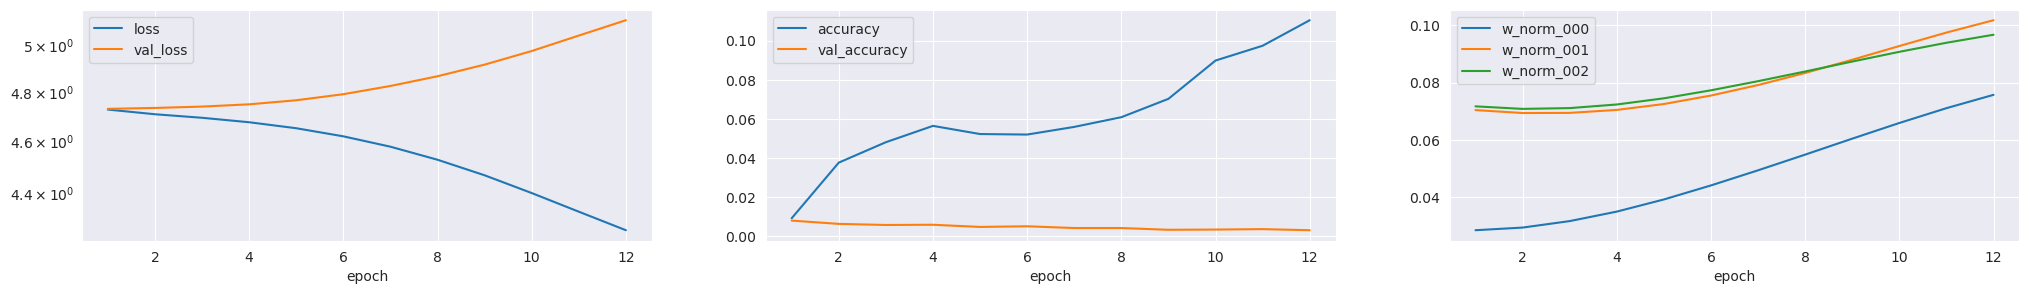

In [8]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1, 3, figsize=(25,3))
    sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
    axs[0].set_yscale("log");
    sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);
    sns.lineplot(data=run.history.loc[:,"w_norm_000":], ax=axs[2], dashes=False);

In [9]:
run.save_state(LOG_DIR, P, model)